# Drug discovery using ChEMBL

ChEMBL is a manually curated chemical database of bioactive molecules with drug-like properties. It is maintained by the European Bioinformatics Institute (EBI), of the European Molecular Biology Laboratory (EMBL), Hinxton, UK.

`insilico` is a Python package to process and model ChEMBL data. It's built on the pre-existing bioinformatics packages `rdkit` and `padelpy`.

#### Table of contents
1.   [Acquire & preprocess molecular data](#acquire)
2.   [Decision tree to predict IC50](#tree)
3.   [TensorFlow](#tensorflow)

## Install dependencies

In [ ]:
%%bash
pip install insilico==0.1.2
pip install chembl_webresource_client
pip install padelpy
pip install rdkit-pypi

In [ ]:
from insilico import target_search, process_target_data

<a name='acquire'></a>
## Acquire & preprocess molecular data

In [ ]:
target_search('coronavirus') #search chembl database

,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [ ]:
target_id = 'CHEMBL3927' #molecule id

In [ ]:
df = process_target_data(target_id) #optional 'fp' param to specify fingerprinter

Query returned 133 molecules for CHEMBL3927
Computing fingerprints (takes several minutes if molecule count 1000+)...
Success!


In [ ]:
df2 = process_target_data(target_id, fp="SubstructureFingerprinter") #optional 'fp' param to specify fingerprinter

Query returned 133 molecules for CHEMBL3927
Computing fingerprints (takes several minutes if molecule count 1000+)...
Success!


In [ ]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0,5.14267,CHEMBL187579,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0,5.02687,CHEMBL188487,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0,4.86967,CHEMBL185698,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0,4.88240,CHEMBL426082,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0,5.69897,CHEMBL187717,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,60200.0,inactive,282.383,4.10530,0.0,2.0,4.22040,CHEMBL45830,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
257,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,78900.0,inactive,282.383,4.10530,0.0,2.0,4.10292,CHEMBL45830,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
258,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,78900.0,inactive,282.383,4.10530,0.0,2.0,4.10292,CHEMBL45830,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
259,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,78900.0,inactive,282.383,4.10530,0.0,2.0,4.10292,CHEMBL45830,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,Name,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,SubFP11,SubFP12,SubFP13,SubFP14,SubFP15,SubFP16,SubFP17,SubFP18,SubFP19,SubFP20,SubFP21,SubFP22,SubFP23,SubFP24,SubFP25,SubFP26,SubFP27,SubFP28,SubFP29,SubFP30,...,SubFP268,SubFP269,SubFP270,SubFP271,SubFP272,SubFP273,SubFP274,SubFP275,SubFP276,SubFP277,SubFP278,SubFP279,SubFP280,SubFP281,SubFP282,SubFP283,SubFP284,SubFP285,SubFP286,SubFP287,SubFP288,SubFP289,SubFP290,SubFP291,SubFP292,SubFP293,SubFP294,SubFP295,SubFP296,SubFP297,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0,5.14267,CHEMBL187579,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0,5.02687,CHEMBL188487,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0,4.86967,CHEMBL185698,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0,4.88240,CHEMBL426082,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0,5.69897,CHEMBL187717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,60200.0,inactive,282.383,4.10530,0.0,2.0,4.22040,CHEMBL45830,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1
257,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,78900.0,inactive,282.383,4.10530,0.0,2.0,4.10292,CHEMBL45830,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1
258,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,78900.0,inactive,282.383,4.10530,0.0,2.0,4.10292,CHEMBL45830,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1
259,CHEMBL45830,CC(C)C1=Cc2ccc3c(c2C(=O)C1=O)CCCC3(C)C,78900.0,inactive,282.383,4.10530,0.0,2.0,4.10292,CHEMBL45830,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,1


In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

SMILES: C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C


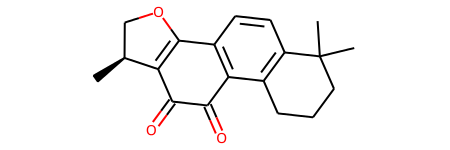

In [ ]:
mol = df.Name[np.random.randint(len(df))]
SMILES = df.canonical_smiles[df.Name==mol].values[0]
print('SMILES:', SMILES)
Chem.MolFromSmiles(SMILES) 

<a name='tree'></a>
## Decision tree regressor to predict IC50

In [ ]:
from sklearn.tree import export_text
from insilico import ModelChembl

In [ ]:
mdl = ModelChembl(df, test_size=.2, var_threshold=.15) #declare class instance, filter and split data
mdl2 = ModelChembl(df2, test_size=.2, var_threshold=.15) #declare class instance, filter and split data

We've dropped features with low variance (under 0.1) thereby reducing the fingerprint from 881 to 100-200 features. Optionally, try to maximize the cross-validation score in order to find the best hyperparameters.

In [ ]:
tree, predictions = mdl.tree(ccp_alpha=.1)

5-Fold cross-validation results:
0.44 r_squared with a standard deviation of 0.07


In [ ]:
tree2, predictions2 = mdl2.tree(ccp_alpha=.1)

5-Fold cross-validation results:
0.46 r_squared with a standard deviation of 0.06


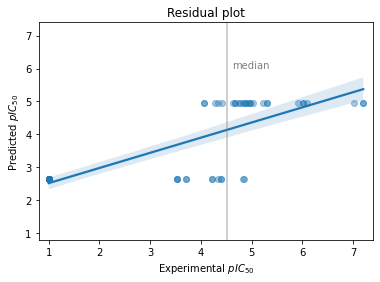

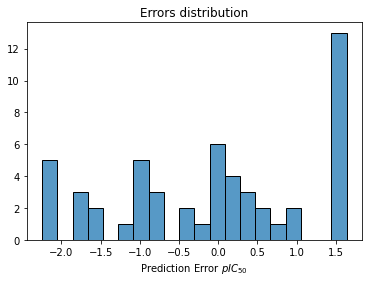

In [ ]:
tree_metrics = mdl.evaluate(predictions2)

In [ ]:
print(export_text(tree2, max_depth=3))

|--- feature_2 <= 0.50
|   |--- value: [4.96]
|--- feature_2 >  0.50
|   |--- value: [2.64]



<a name='tensorflow'></a>
## TensorFlow

From the [basic regression TensorFlow tutorial](https://www.tensorflow.org/tutorials/keras/regression)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
X_train, X_test, y_train, y_test = mdl.get_data()

In [ ]:
X_train

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [ ]:
y_train.describe()

count    208.000000
mean       3.962999
std        1.678424
min        1.000000
25%        3.522880
50%        4.522880
75%        4.970620
max        7.301030
Name: pIC50, dtype: float64

When numeric input data features have values with different ranges, each feature should be scaled independently to the same range using an initial normalization layer. In this case, normalization isn't necessary because all the inputs are binary. 

Overfitting is a common problem for DNN models, though regularization didn't help much here. If used, add it to the Dense layers after the activation function. Alternatively, put Dropout layers between the Dense layers.


In [ ]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model()
dnn_model.predict(X_train[:5]) #untrained predictions

array([[ 0.79925525],
       [ 0.07098158],
       [-0.19063076],
       [ 0.9230417 ],
       [ 0.67430586]], dtype=float32)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [pIC50]')
  plt.legend()
  plt.grid(True)

In [ ]:
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               26112     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 42,753
Trainable params: 42,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = dnn_model.fit(X_train, y_train, epochs=50, #batch_size=4,
                        verbose=0, validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.958606,1.255593,95
96,0.939398,1.317523,96
97,0.914426,1.304337,97
98,0.911650,1.338695,98
99,0.911605,1.325877,99


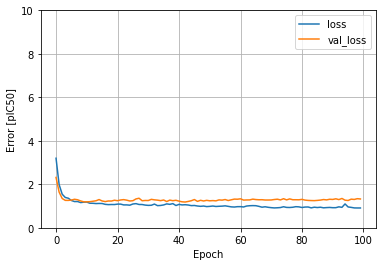

In [ ]:
plot_loss(history)


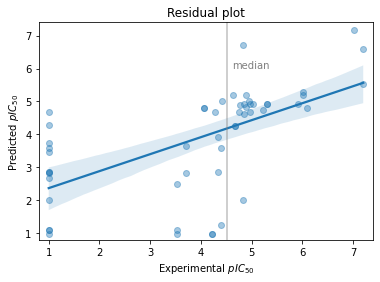

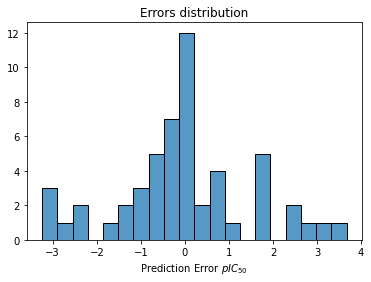

In [ ]:
dnn_predictions = dnn_model.predict(X_test).flatten()
dnn_metrics = mdl.evaluate(dnn_predictions)

In [ ]:
pd.DataFrame([tree_metrics, dnn_metrics], index=["tree", "DNN"])

,support,mean_absolute_error,r_squared
tree,53,1.10088,0.48754
DNN,53,1.13086,0.28582
